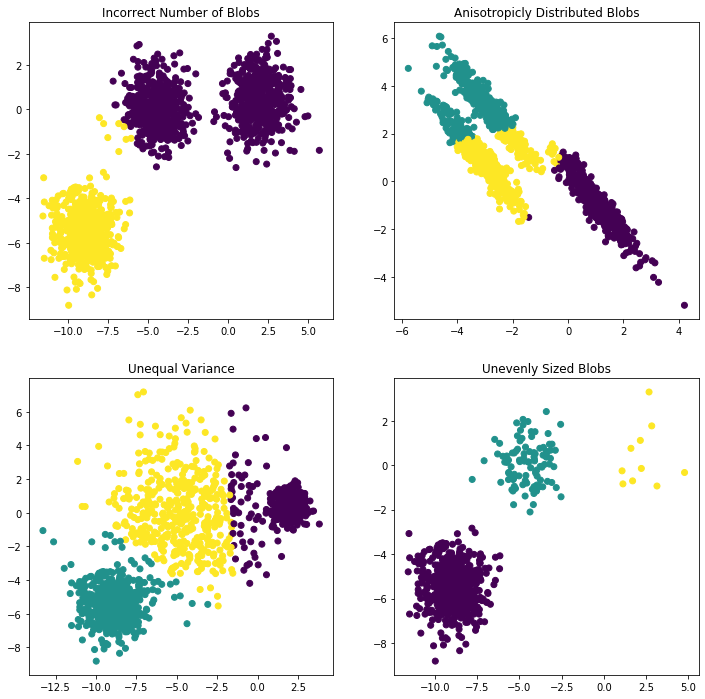

In [2]:
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

In [3]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [4]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


k-means++	0.172s	69662	0.680	0.719	0.699	0.570	0.676	0.205
random   	0.128s	69707	0.675	0.716	0.694	0.560	0.671	0.163
PCA-based	0.050s	74152	0.653	0.683	0.668	0.539	0.650	0.124
__________________________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


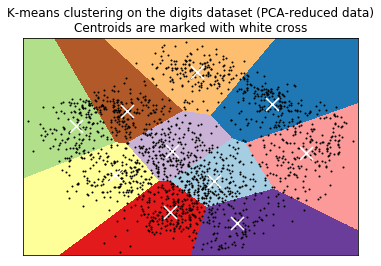

In [6]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

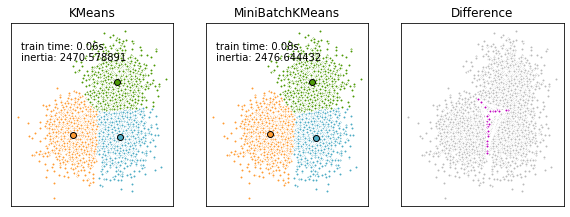

In [7]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

Computing embedding
Done.
ward :	0.55s
average :	0.41s
complete :	0.58s
single :	0.22s


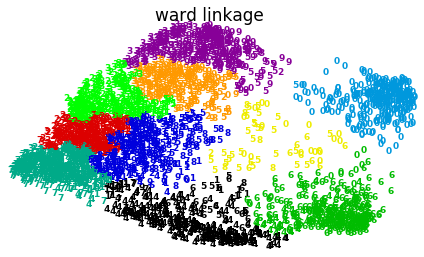

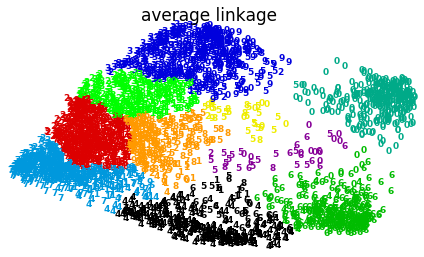

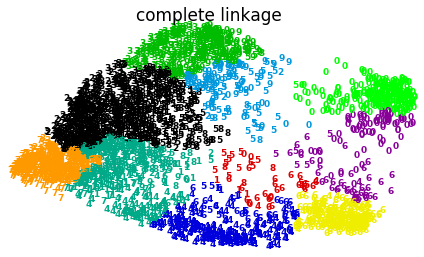

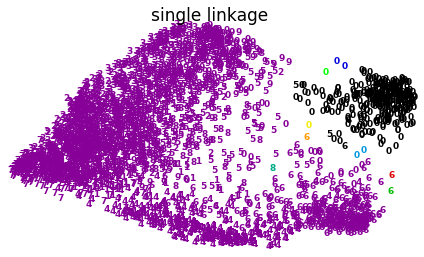

In [13]:
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape

np.random.seed(0)


def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(
        x.reshape((8, 8)), 0.3 * np.random.normal(size=2), mode="constant"
    ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(
            X_red[i, 0],
            X_red[i, 1],
            str(y[i]),
            color=plt.cm.nipy_spectral(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

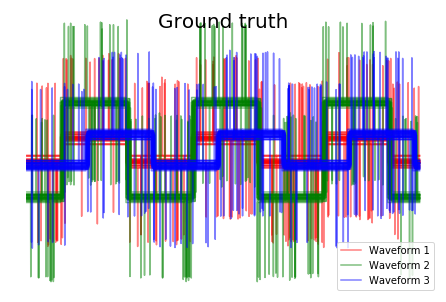

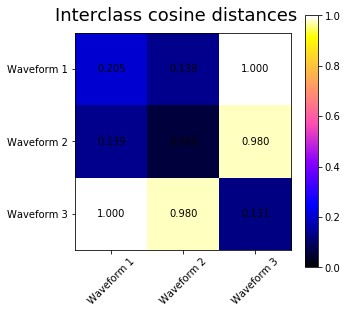

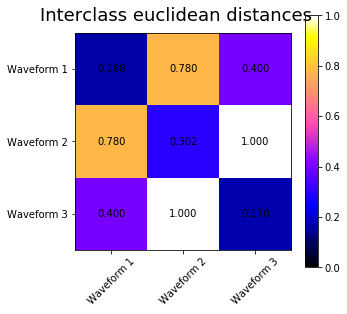

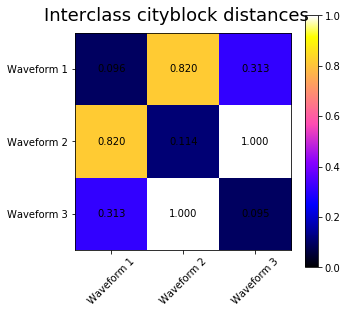

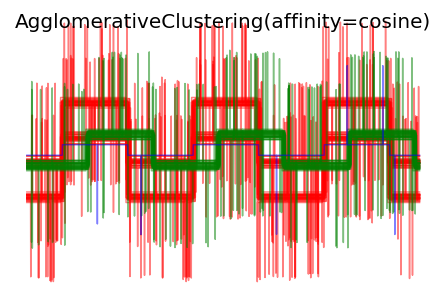

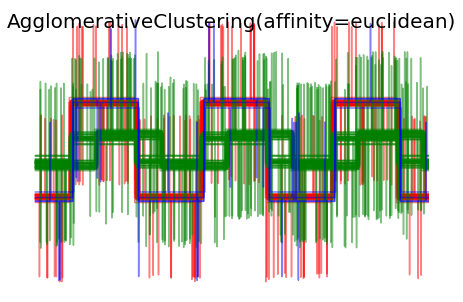

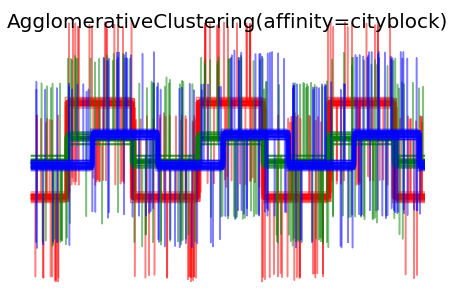

In [14]:
# License: BSD 3-Clause or CC-0

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))


X = list()
y = list()
for i, (phi, a) in enumerate([(0.5, 0.15), (0.5, 0.6), (0.3, 0.2)]):
    for _ in range(30):
        phase_noise = 0.01 * np.random.normal()
        amplitude_noise = 0.04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < 0.997] = 0

        X.append(
            12
            * (
                (a + amplitude_noise) * (sqr(6 * (t + phi + phase_noise)))
                + additional_noise
            )
        )
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ("Waveform 1", "Waveform 2", "Waveform 3")

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), "rgb", labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")

plt.axis("tight")
plt.axis("off")
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y == i], X[y == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(
                i,
                j,
                "%5.3f" % avg_dist[i, j],
                verticalalignment="center",
                horizontalalignment="center",
            )

    plt.imshow(avg_dist, interpolation="nearest", cmap=plt.cm.gnuplot2, vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", affinity=metric
    )
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), "rgbk"):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=0.5)
    plt.axis("tight")
    plt.axis("off")
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


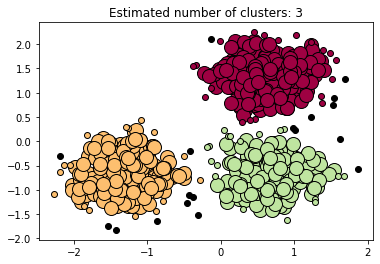

In [15]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

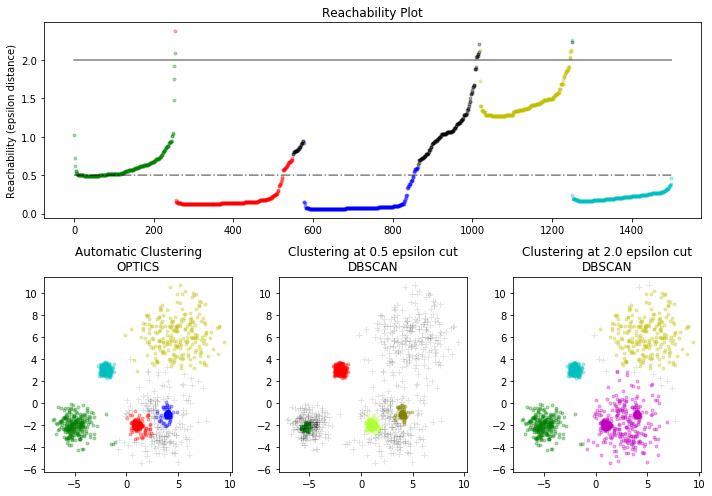

In [16]:
# License: BSD 3 clause

from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + 0.8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + 0.1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + 0.2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + 0.3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

Computing adjusted_rand_score for 10 values of n_clusters and n_samples=100
done in 0.044s
Computing v_measure_score for 10 values of n_clusters and n_samples=100
done in 0.064s
Computing ami_score for 10 values of n_clusters and n_samples=100


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


done in 0.592s
Computing mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.048s
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=1000
done in 0.075s
Computing v_measure_score for 10 values of n_clusters and n_samples=1000
done in 0.090s
Computing ami_score for 10 values of n_clusters and n_samples=1000
done in 0.326s
Computing mutual_info_score for 10 values of n_clusters and n_samples=1000
done in 0.065s


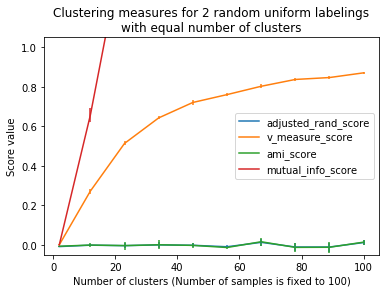

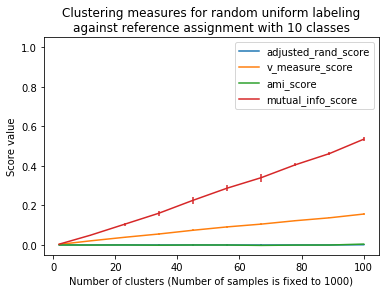

In [17]:
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics


def uniform_labelings_scores(
    score_func, n_samples, n_clusters_range, fixed_n_classes=None, n_runs=5, seed=42
):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range), n_runs))

    if fixed_n_classes is not None:
        labels_a = random_labels(low=0, high=fixed_n_classes, size=n_samples)

    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0, high=k, size=n_samples)
            labels_b = random_labels(low=0, high=k, size=n_samples)
            scores[i, j] = score_func(labels_a, labels_b)
    return scores


def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)


score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]

# 2 independent random clusterings with equal cluster number

n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print(
        "Computing %s for %d values of n_clusters and n_samples=%d"
        % (score_func.__name__, len(n_clusters_range), n_samples)
    )

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    print("done in %0.3fs" % (time() - t0))
    plots.append(
        plt.errorbar(n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0]
    )
    names.append(score_func.__name__)

plt.title(
    "Clustering measures for 2 random uniform labelings\nwith equal number of clusters"
)
plt.xlabel("Number of clusters (Number of samples is fixed to %d)" % n_samples)
plt.ylabel("Score value")
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)


# Random labeling with varying n_clusters against ground class labels
# with fixed number of clusters

n_samples = 1000
n_clusters_range = np.linspace(2, 100, 10).astype(int)
n_classes = 10

plt.figure(2)

plots = []
names = []
for score_func in score_funcs:
    print(
        "Computing %s for %d values of n_clusters and n_samples=%d"
        % (score_func.__name__, len(n_clusters_range), n_samples)
    )

    t0 = time()
    scores = uniform_labelings_scores(
        score_func, n_samples, n_clusters_range, fixed_n_classes=n_classes
    )
    print("done in %0.3fs" % (time() - t0))
    plots.append(
        plt.errorbar(n_clusters_range, scores.mean(axis=1), scores.std(axis=1))[0]
    )
    names.append(score_func.__name__)

plt.title(
    "Clustering measures for random uniform labeling\n"
    "against reference assignment with %d classes" % n_classes
)
plt.xlabel("Number of clusters (Number of samples is fixed to %d)" % n_samples)
plt.ylabel("Score value")
plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()

Экзамен

In [1]:
# Загрузить библиотеки 
from sklearn.tree import DecisionTreeCiassifier 
from sklearn import datasets
# Загрузить данные 
iris = datasets.load_iris()


ImportError: cannot import name 'DecisionTreeCiassifier' from 'sklearn.tree' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\__init__.py)